## MXNet

MXNet is a deep learning framework designed for both efficiency and flexibility. It allows you to mix the flavours of symbolic programming and imperative programming to maximize efficiency and productivity. In its core, a dynamic dependency scheduler that automatically parallelizes both symbolic and imperative operations on the fly. A graph optimization layer on top of that makes symbolic execution fast and memory efficient. The library is portable and lightweight, and it scales to multiple GPUs and multiple machines.

#### Digit Recognition on MNIST :

The MNIST dataset consists of 60000 labelled data for digits 0-9. The test data comprises of 10000 labelled images. The digits have all been size-normalised and centered in a fixed-size image.

#### To view the images : 

The Julia package MNIST.jl is very convenient to handle and view all the images in the dataset.

In [82]:
#=
using MNIST
trainX, trainY = traindata()
testX, testY = testdata()
=#
function showtestdigit(d::Int64)
    a = zeros(28,28)
    j=1
    for i=1:28:length(testX[:,d])-27
        a[:,j]= testX[:,d][i:i+27]
        j = j+1
    end
    grayim(a)
end

function showtraindigit(d::Int64)
    a = zeros(28,28)
    j=1
    for i=1:28:length(trainX[:,d])-27
        a[:,j]= trainX[:,d][i:i+27]
        j = j+1
    end
    grayim(a)
end

showtraindigit (generic function with 1 method)

trainY[1] = 5.0


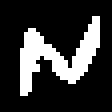

In [86]:
@show trainY[1]
showtraindigit(1)

In [10]:
# GPU specific configurations
ENV["MXNET_HOME"] = joinpath(Pkg.dir("MXNet"), "deps", "usr", "lib")
Base.compilecache("MXNet")
using MXNet

Create a placeholder for the data.

In [11]:
data = mx.Variable(:data)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00000000096c2a00))

This is a 3 layer cascaded fully-connected network. Note the architecture looks like,
#### Input --> 128 units (ReLU) --> 64 units (ReLU) --> 10 units

In [12]:
fc1  = mx.FullyConnected(data = data, name=:fc1, num_hidden=128)
act1 = mx.Activation(data = fc1, name=:relu1, act_type=:relu)
fc2  = mx.FullyConnected(data = act1, name=:fc2, num_hidden=64)
act2 = mx.Activation(data = fc2, name=:relu2, act_type=:relu)
fc3  = mx.FullyConnected(data = act2, name=:fc3, num_hidden=10)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x000000000a679fe0))

We then add a final SoftmaxOutput operation to turn the 10-dimensional prediction to proper probability values for the 10 classes.

In [13]:
mlp  = mx.SoftmaxOutput(data = fc3, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x0000000005e3a790))

As we can see, the MLP is just a chain of layers. 
For this case, we can also use the mx.chain macro. 
The same architecture above can be defined as,

In [ ]:
mlp = @mx.chain mx.Variable(:data)             =>
  mx.FullyConnected(name=:fc1, num_hidden=128) =>
  mx.Activation(name=:relu1, act_type=:relu)   =>
  mx.FullyConnected(name=:fc2, num_hidden=64)  =>
  mx.Activation(name=:relu2, act_type=:relu)   =>
  mx.FullyConnected(name=:fc3, num_hidden=10)  =>
  mx.SoftmaxOutput(name=:softmax)

After defining the architecture, we are ready to load the MNIST data. MXNet.jl provide built-in data providers for the MNIST dataset, which could automatically download the dataset into Pkg.dir("MXNet")/data/mnist if necessary. 

In [15]:
batch_size = 100
include(Pkg.dir("MXNet", "examples", "mnist", "mnist-data.jl"))
train_provider, eval_provider = get_mnist_providers(batch_size)

(MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x0000000006c71a20),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true),MXNet.mx.MXDataProvider(MXNet.mx.MX_DataIterHandle(Ptr{Void} @0x000000000a73ede0),Tuple{Symbol,Tuple}[(:data,(784,100))],Tuple{Symbol,Tuple}[(:softmax_label,(100,))],100,true,true))

Given the architecture and data, we can instantiate an model to do the actual training. mx.FeedForward is the built-in model that is suitable for most feed-forward architectures. When constructing the model, we also specify the context on which the computation should be carried out. 

In [16]:
model = mx.FeedForward(mlp, context=mx.gpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x0000000006391980)),[GPU0],#undef,#undef,#undef)

The last thing we need to specify is the optimization algorithm (a.k.a. optimizer) to use. We use the basic SGD with a fixed learning rate 0.1 and momentum 0.9:

In [17]:
optimizer = mx.SGD(lr=0.1, momentum=0.9, weight_decay=0.00001)

MXNet.mx.SGD(MXNet.mx.SGDOptions(0.1,0.9,0,1.0e-5,MXNet.mx.LearningRate.Fixed(0.1),MXNet.mx.Momentum.Fixed(0.9)),#undef)

Now we can do the training. Here the n_epoch parameter specifies that we want to train for 20 epochs. We also supply a eval_data to monitor validation accuracy on the validation set.

In [18]:
@time mx.fit(model, optimizer, train_provider, n_epoch=20, eval_data=eval_provider)


INFO: Start training on [GPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 0 MB allocated on GPU0
INFO: Start training...
INFO: == Epoch 001 ==========
INFO: ## Training summary
INFO:           accuracy = 0.7612
INFO:               time = 1.1682 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9517
INFO: == Epoch 002 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9570
INFO:               time = 1.1841 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9632
INFO: == Epoch 003 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9721
INFO:               time = 1.0910 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9671
INFO: == Epoch 004 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9788
INFO:               time = 1.0987 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9710
INFO: == Epoch 005 ==========
INFO: ## Training summary
INFO:   

 23.265697 seconds (25.60 M allocations: 785.561 MB, 2.76% gc time)


INFO: ## Training summary
INFO:           accuracy = 0.9955
INFO:               time = 1.0406 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9764


In [19]:
probs = mx.predict(model, eval_provider)

INFO: TempSpace: Total 0 MB allocated on GPU0


10x10000 Array{Float32,2}:
 1.18017e-13  4.66625e-11  5.94254e-13  …  5.03603e-17  1.74815e-17
 9.97845e-8   1.02892e-15  1.0             8.10943e-26  7.31301e-28
 4.26053e-11  1.0          3.2402e-9       1.11811e-26  4.61356e-22
 1.75137e-11  3.18971e-11  7.25488e-16     3.54733e-17  1.57084e-27
 1.58637e-10  3.52805e-24  6.52529e-10     2.87558e-23  5.32044e-28
 1.49787e-13  1.09843e-18  1.78361e-12  …  1.0          1.14402e-16
 2.07817e-17  7.18221e-22  1.55943e-12     6.01975e-13  1.0        
 1.0          9.51499e-15  1.54013e-8      1.99687e-23  6.85008e-36
 2.6341e-12   8.3323e-17   1.59e-9         1.22983e-9   5.93987e-18
 2.96877e-11  1.43315e-22  4.8427e-15      1.35876e-19  7.23316e-23

In [20]:
# collect all labels from eval data
labels = Array[]
for batch in eval_provider
    push!(labels, copy(mx.get(eval_provider, batch, :softmax_label)))
end
labels = cat(1, labels...)


10000-element Array{Float32,1}:
 7.0
 2.0
 1.0
 0.0
 4.0
 1.0
 4.0
 9.0
 5.0
 9.0
 0.0
 6.0
 9.0
 ⋮  
 5.0
 6.0
 7.0
 8.0
 9.0
 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0

In [22]:
# Now we use compute the accuracy
correct = 0
for i = 1:length(labels)
    # labels are 0...9
    if indmax(probs[:,i]) == labels[i]+1
        correct += 1
    end
end
accuracy = 100correct/length(labels)
println(mx.format("Accuracy on eval set: {1:.2f}%", accuracy))

Accuracy on eval set: 97.64%


labels[1231] = 4.0f0


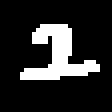

In [81]:
@show labels[1231]
showtestdigit(1231)

### Performance :

INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.4/Compose.ji for module Compose.
INFO: Recompiling stale cache file /home/ubuntu/.julia/lib/v0.4/Gadfly.ji for module Gadfly.
    .<(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/ubuntu/.julia/v0.4/DataArrays/src/broadcast.jl:339
is ambiguous with: 
    .<(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /home/ubuntu/.julia/v0.4/Images/src/algorithms.jl:177.
To fix, define 
    .<(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .<(AbstractArray, Union{DataArrays.PooledDataArray, DataArrays.DataArray}) at /home/ubuntu/.julia/v0.4/DataArrays/src/broadcast.jl:294
is ambiguous with: 
    .<(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /home/ubuntu/.julia/v0.4/Images/sr

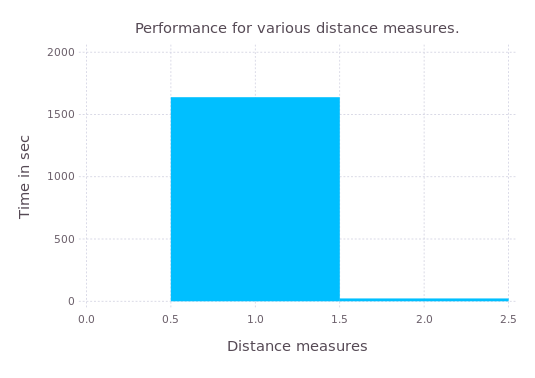

In [91]:
t = [1639,23]
using Gadfly
p1=Gadfly.plot( y=t, Guide.xlabel("Distance measures"), Guide.ylabel("Time in sec"), Geom.bar, Guide.title("Performance for various distance measures."))
